In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

import ksource_py as ks
import mcpl

In [ ]:
%matplotlib notebook

# Abrir tally

### INPUT: Completar plantilla en una celda duplicada

In [ ]:
# Plantilla

outputfile = "filename"
tallyname = "tally"
spectrum = "spectrum"

tally = ks.T4Tally(outputfile, tallyname)

In [2]:
# Mapa activacion Fe-58 en bunker

outputfile = "2_bunker_n/2_bunker_n.out"
tallyname = "mapa_activ_fe"
spectrum = "Decay/Fe59.csv"

tally = ks.T4Tally(outputfile, tallyname, spectrum)

Tally mapa_activ_fe leido exitosamente


# Crear graficos

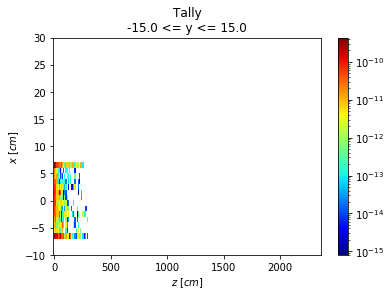

In [3]:
cell = None # Indice de celda en direccion normal a pantalla. None: promediar todas

[fig, [scores,errs]] = tally.plot2D(['z', 'x'], cell=cell)

# Guardar como lista de tracks

In [4]:
tracksfile = None # Usar nombre default

tracksfile = tally.save_tracks(tracksfile)

Using existing file 2_bunker_n/mapa_activ_fe.mcpl.gz
Lista de tracks guardada exitosamente en 2_bunker_n/mapa_activ_fe.mcpl.gz


# Crear KSource

In [5]:
# Abrir lista de particulas

tracksfile = tracksfile
tracksformat = "mcpl"
pt = "p"
trasl = None
rot = None
x2z = False

set_params = True
plist = ks.PList(tracksformat, tracksfile, pt=pt, trasl=trasl, rot=rot, switch_x2z=x2z, set_params=set_params)

# Crear Geometria

trasl = None
rot = None
volparams = [tally.grids[0][0], tally.grids[0][-1],
             tally.grids[1][0], tally.grids[1][-1],
             tally.grids[2][0], tally.grids[2][-1]]
metric = ks.Geometry([ks.Lethargy(10), ks.Vol(*volparams), ks.Isotrop()], trasl=trasl, rot=rot)

#Crear KSource

J = 1
s = ks.KSource(plist, metric, bw="silv", J=J)

Using existing file 2_bunker_n/mapa_activ_fe.mcpl.gz
I = 95399.65959695482
p2 = 90054311.41031013
N = 7328


# Evaluar estadistica

------------------------------------------------------------------------------
nparticles   : 7328
sum(weights) : 95399.7
------------------------------------------------------------------------------
             :            mean             rms             min             max
------------------------------------------------------------------------------
ekin   [MeV] :         1.14094        0.220427        0.142651          1.4817
x       [cm] :        -1.11085         5.10169            -6.5             6.5
y       [cm] :        -3.64772         9.77814           -13.5            13.5
z       [cm] :          41.985         43.3059               5             295
ux           :               0               0               0               0
uy           :               0               0               0               0
uz           :               1               0               1               1
time    [ms] :               0               0               0               0
weight   

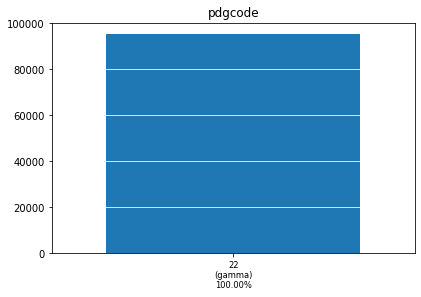

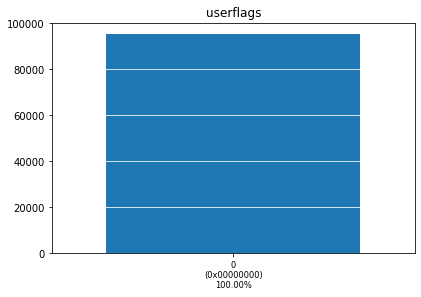

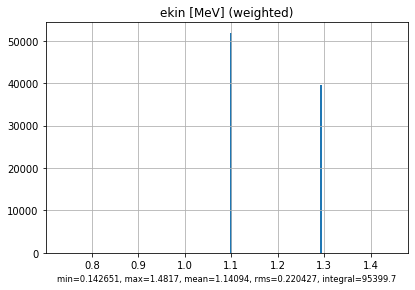

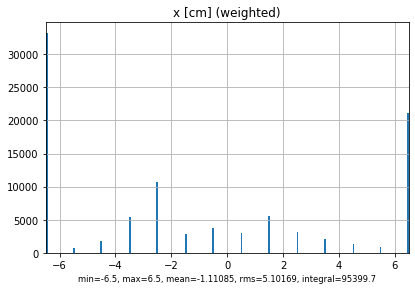

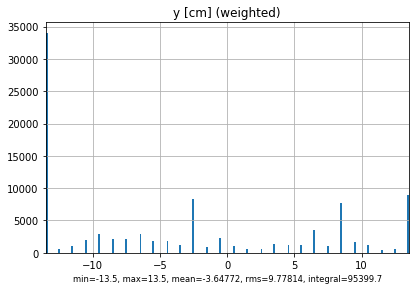

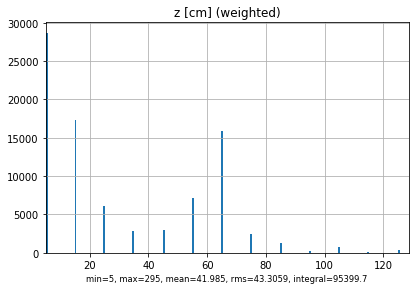

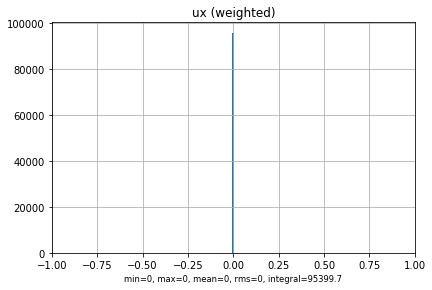

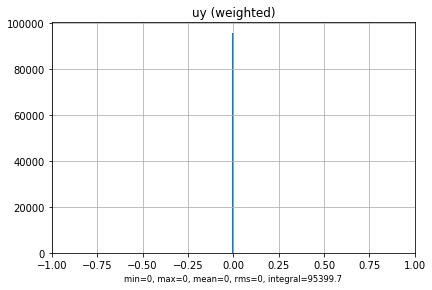

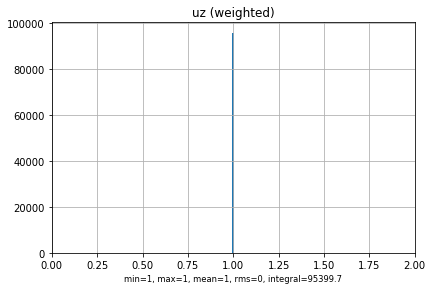

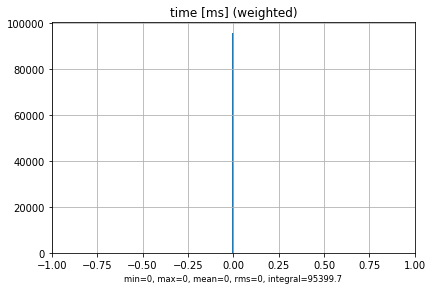

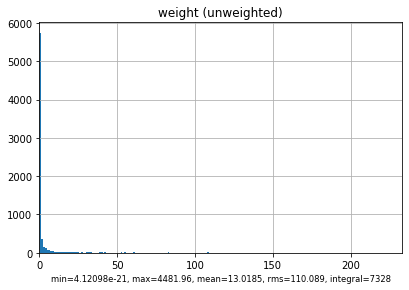

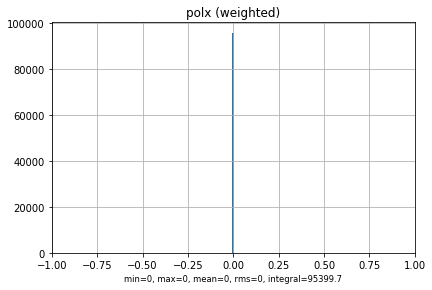

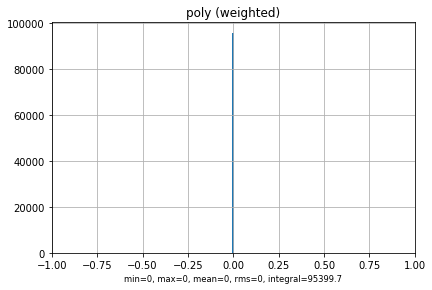

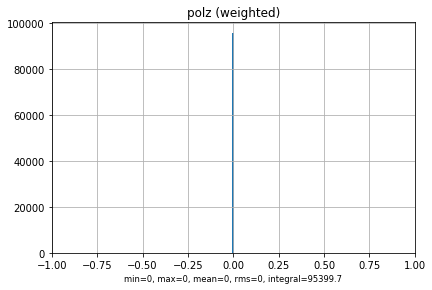

In [7]:
# Con MCPL

file = s.plist.filename
mcpl.dump_stats(mcpl.collect_stats(file))
mcpl.plot_stats(file)

/home/inti/Documents/Maestria/Simulaciones/ksource_py/aux.py:49: RuntimeWarning: divide by zero encountered in log
  log_E = np.log(1E-6*E)
/home/inti/Documents/Maestria/Simulaciones/ksource_py/aux.py:50: RuntimeWarning: divide by zero encountered in log
  log_H10 = np.log(1E-12*H10)


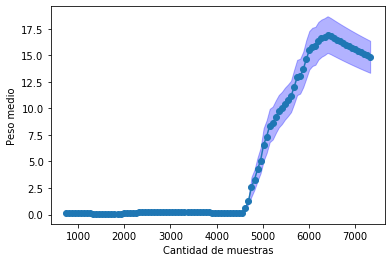

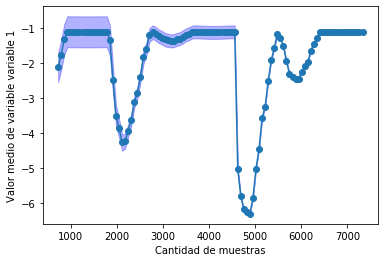

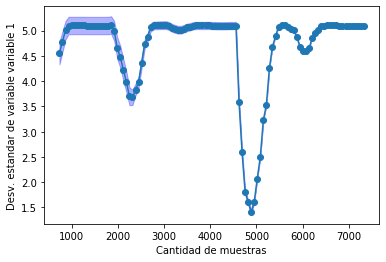

In [5]:
# Con ks.Stats

# Intervalos de variables (box)
maskfun = ks.Box(None, None)

# Funcion de peso
fact_dosim = ks.H10(pt=plist.pt)
weightfun = lambda parts: parts[:,0]

parts,ws = plist.get()
stats = ks.Stats(parts, ws, weightfun=weightfun, maskfun=maskfun)

N,I,err = stats.mean_weight(steps=100)
plt.show()
N,mn,err = stats.mean(var=1, steps=100)
plt.show()
N,mn,err = stats.std(var=1, steps=100)
plt.show()

# Optimizar BW (revisar)

In [6]:
# Metodo de Silverman

s.bw_method = "silv"
N = 1E4
s.fit(N, N_tot=2991283)
s.bw[0] = 0 # Energias discretas
s.bw[4] = s.bw[5] = s.bw[6] = np.inf # Emision isotropica

Usando 7328 particulas para entrenamiento
Calculando bw ... 
Hecho
Optimal bw (silv) = [ 0.211  1.316  2.457 15.246  0.     0.     0.   ]


Usando 7328 particulas para entrenamiento
Calculando bw ... 
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.3s
[Parallel(

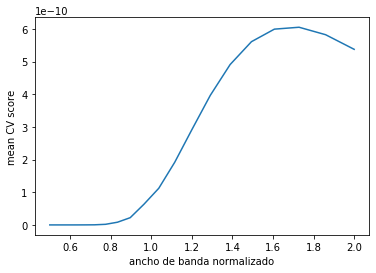

Verificar que el grafico presenta un maximo
Hecho
Optimal bw (mlcv) = [0.063 0.393 0.733 4.552 1.728 1.728 1.728]


In [7]:
# Metodo de Max Likelihood Cross Validation

s.bw_method = "mlcv"
N = 1E4
s.fit(N, N_tot=s.plist.N, steps=20, max_fact=2, shift=.1)
s.bw[0] = 0 # Energias discretas
s.bw[4] = s.bw[5] = s.bw[6] = np.inf # Emision isotropica

In [8]:
# Metodo de K Nearest Neighbours

s.bw_method = "knn"
N = 1e5
s.fit(N)#, N_tot=100000)#2991283)
s.bw[:,0] = 0 # Energias discretas
s.bw[:,4] = s.bw[:,5] = s.bw[:,6] = np.inf # Emision isotropica

print("Mean bw:")
print(s.bw.mean(axis=0))

Usando 7328 particulas para entrenamiento
Calculando bw ... 
Usando K = 10
batch = 1 / 1
Hecho
Optimal bw (knn) = [[0.294 1.832 3.419 ... 0.333 0.333 0.333]
 [0.258 1.608 3.    ... 0.292 0.292 0.292]
 [0.277 1.727 3.223 ... 0.314 0.314 0.314]
 ...
 [0.277 1.727 3.223 ... 0.314 0.314 0.314]
 [0.309 1.927 3.596 ... 0.351 0.351 0.351]
 [0.424 2.642 4.931 ... 0.481 0.481 0.481]]
Mean bw:
[ 0.     1.607  2.999 18.612    inf    inf    inf]


In [ ]:
# Graficos de bw variable

if N>s.plist.N: N = s.plist.N
bws = (s.bw / s.metric.std(vecs=s.vecs))[:,0]

Es = s.metric.E.inverse_transform(s.vecs[:N,0])
plt.plot(Es, bws, 'o')
plt.ylabel("bandwidth")
plt.xlabel("E [MeV]")
plt.xscale("log")
plt.show()

xs = s.vecs[:N,1]
ys = s.vecs[:N,2]
plt.scatter(xs, ys, c=bws)
plt.colorbar()
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.show()

mus = s.vecs[:N,5]
plt.plot(mus, bws, 'o')
plt.ylabel("bandwidth")
plt.xlabel("mu []")
plt.show()

# Guardar KSource

In [9]:
sourcefilename = None
bwfilename = None # Solo si bw variable

s.save(sourcefilename, bwfilename)

Archivo de definicion de fuente: 2_bunker_n/mapa_activ_fe_source.txt
Archivo de anchos de banda: 2_bunker_n/mapa_activ_fe_bws.ssv
